In [120]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re

In [121]:
os.path.abspath(os.curdir)

'/mnt/c/Users/crulis/Documents/projects/yolo_tdid_github'

In [122]:
result_dir = Path('../yolo_tdid/results')
# result_dir = Path('results_wc_gqa')
files = list(result_dir.glob('*.csv'))

In [123]:
files

[PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-10_bias-False_augment-False_seed-377084.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-10_bias-False_augment-True_seed-472439.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-1_bias-False_augment-False_seed-564248.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-1_bias-False_augment-True_seed-606692.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-3_bias-False_augment-False_seed-312979.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-3_bias-False_augment-True_seed-621053.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-False_n-19_k-5_bias-False_augment-False_seed-122331.csv'),
 PosixPath('../yolo_tdid/results/yolow-l_sighted-True_clutter-False_hand-Fals

append model size column

In [124]:
files[0].stem

'yolow-l_sighted-True_clutter-False_hand-False_n-19_k-10_bias-False_augment-False_seed-377084'

In [125]:
def load(path):
    files = path.iterdir()
    name_re = re.compile(r"yolow-(?P<size>.)_sighted-(?P<sighted>.+)_clutter-(?P<clutter>.+)_hand-(?P<hand>.+)_n-(?P<n>\d+)_k-(?P<k>\d+)_bias-.+_augment-(?P<augment>True|False+)(_use_wc-(?P<wc>.+))?_seed-(?P<seed>\d+).*")

    dfs = []

    for f in files:
        m = name_re.match(f.stem)
        if m is None:
            print(f"Skipping {f}")
            continue
        try:
            df = pd.read_csv(f)
            df['size'] = m.group("size")
            df['train blind'] = m.group("sighted") == "False"
            df['train clutter'] = m.group("clutter") == "True"
            df['train hand'] = m.group("hand") == "True"
            df['n_objects'] = int(m.group("n"))
            df['k_examples'] = int(m.group("k"))
            df['augment'] = m.group("augment") == "True"
            df['WC'] = m.group("wc") == "True"
            dfs.append(df)
        except Exception as e:
            print(e)
            print("skipping file")

    df = pd.concat(dfs, ignore_index=True)
    return df

In [126]:
df = load(result_dir)

In [127]:
df.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC'],
      dtype='object')

In [128]:
df = df[df["train hand"] == False] # only keep training images with no hand

In [129]:
any(df["train hand"])

False

In [130]:
cls_mapping = ['airborne gum', 'aspirin', 'baked cheetos', 'baked lays chips', 'cheerios cereal', 'chicken soup can', 'diet coke bottle', 'dr pepper can', 'extra dry skin moisturizer', 'great grains cereal', 'grill salt', 'hand sanitizer', 'hand soap', 'mandarin can', 'mountain dew can', 'oregano', 'regular coke bottle', 'spf55 sunscreen', 'sprite bottle']

In [131]:
df["target class name"] = df["target_class"].apply(lambda x: cls_mapping[x])

In [132]:
df_a = df[df["augment"]]    # with augmentations
df_b = df[~df["augment"]]   # without augmentations (base)

In [133]:
# number of sample per object class
df_a.groupby("target class name").size()

target class name
airborne gum                  116460
aspirin                       111780
baked cheetos                 112140
baked lays chips              116640
cheerios cereal               115200
chicken soup can              120960
diet coke bottle              116460
dr pepper can                 112320
extra dry skin moisturizer    113580
great grains cereal           117000
grill salt                    115380
hand sanitizer                113220
hand soap                     119700
mandarin can                  115020
mountain dew can              120600
oregano                       111600
regular coke bottle           115920
spf55 sunscreen               122580
sprite bottle                 116640
dtype: int64

In [134]:
prob_cols = [f"prob_cls_{i}" for i in range(19)]

# General accuracy

In [135]:
df_b["correct"].mean()

0.26785629992737836

In [136]:
df_a["correct"].mean()

0.30390613652868553

In [137]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False) & (df_a["clutter"] == False) & (df_a["k_examples"] == 10)]["correct"].mean()

0.3628867102396514

In [138]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False)]["correct"].mean()

0.3110852396514161

In [139]:
df_a[(df_a["blind"] == False) & (df_a["train blind"] == False) & (df_a["clutter"] == False)]["correct"].mean()

0.3440291394335512

# Breakdown by model

In [140]:
df.groupby(['size', 'n_objects', 'k_examples'])['correct'].mean()

size  n_objects  k_examples
l     2          1             0.732454
                 3             0.754306
                 5             0.766991
                 10            0.821343
      4          1             0.517153
                 3             0.570787
                 5             0.545162
                 10            0.590069
      9          1             0.319198
                 3             0.342521
                 5             0.348220
                 10            0.374578
      19         1             0.188835
                 3             0.205283
                 5             0.207096
                 10            0.211257
m     2          1             0.722870
                 3             0.759907
                 5             0.724907
                 10            0.742824
      4          1             0.499028
                 3             0.534190
                 5             0.547245
                 10            0.525046
      9     

In [141]:
df1 = df[df["train blind"] == False]

In [142]:
out1 = df1.groupby(['size', 'n_objects', 'k_examples', 'augment', 'seed'])["correct"].mean()\
    .groupby(['size', 'n_objects', 'k_examples', 'augment']).agg(('mean', 'std'))

In [143]:
# put model sizes and augment in columns
# descend mean and row columns to the lower level
# out1.unstack(level=[3, 0])
pivoted = out1.pivot_table(values=["mean", "std"], index=['n_objects', 'k_examples'], columns=["augment", "size"])
pivoted = pivoted.reorder_levels([1, 2, 0], axis=1)
pivoted = pivoted.sort_index(axis=1, level=[2], sort_remaining=False, ascending=False)\
    .sort_index(axis=1, level=[1], ascending=False, sort_remaining=False)\
    .sort_index(axis=1, level=[0], sort_remaining=False)
pivoted

augment                  False                                          \
size                         s                   m                   l   
                          mean       std      mean       std      mean   
n_objects k_examples                                                     
2         1           0.646574  0.149598  0.724074  0.156686  0.708426   
          3           0.743611  0.156793  0.730556  0.148079  0.739630   
          5           0.698241  0.151756  0.711944  0.145749  0.753889   
          10          0.715370  0.150108  0.766481  0.145823  0.792315   
4         1           0.398704  0.102094  0.477500  0.122954  0.492269   
          3           0.515741  0.124590  0.515648  0.132311  0.542269   
          5           0.490324  0.134160  0.537731  0.133061  0.498333   
          10          0.458426  0.137420  0.525093  0.112978  0.536343   
9         1           0.244486  0.062431  0.274300  0.063927  0.279342   
          3           0.252016  0.076525  0.303848  0.060699  0.317222   
          5           0.257798  0.063772  0.307387  0.058830  0.316276   
          10          0.270288  0.081299  0.303189  0.052831  0.352798   
19        1           0.116160  0.025081  0.155312  0.030882  0.177076   
          3           0.143645  0.021848  0.165107  0.019946  0.182456   
          5           0.138665  0.020353  0.172788  0.014371  0.179405   
          10          0.133821  0.012795  0.174513  0.011759  0.185214   

augment                            True                                 \
size                                   s                   m             
                           std      mean       std      mean       std   
n_objects k_examples                                                     
2         1           0.160699  0.673611  0.151261  0.721667  0.152502   
          3           0.174492  0.759167  0.150457  0.789259  0.136264   
          5           0.111776  0.740556  0.160829  0.737870  0.147376   
          10          0.129181  0.745185  0.160732  0.719167  0.156399   
4         1           0.139483  0.462917  0.111566  0.520556  0.124775   
          3           0.143656  0.500417  0.113275  0.552731  0.107372   
          5           0.112045  0.493796  0.126376  0.556759  0.116745   
          10          0.127614  0.494907  0.120202  0.525000  0.087677   
9         1           0.067753  0.248827  0.063667  0.308868  0.058491   
          3           0.064910  0.273457  0.060106  0.339630  0.060327   
          5           0.049512  0.293642  0.056778  0.352942  0.066993   
          10          0.071963  0.295329  0.056263  0.361111  0.065048   
19        1           0.025810  0.141199  0.026853  0.168187  0.030135   
          3           0.024941  0.156316  0.019659  0.206033  0.024137   
          5           0.016605  0.167534  0.016935  0.201442  0.015727   
          10          0.012030  0.167057  0.013745  0.216559  0.015564   

augment                                   
size                         l            
                          mean       std  
n_objects k_examples                      
2         1           0.756481  0.135305  
          3           0.768981  0.159333  
          5           0.780093  0.170494  
          10          0.850370  0.108704  
4         1           0.542037  0.105405  
          3           0.599306  0.125496  
          5           0.591991  0.125607  
          10          0.643796  0.119101  
9         1           0.359053  0.078650  
          3           0.367819  0.065219  
          5           0.380165  0.063018  
          10          0.396358  0.057371  
19        1           0.200595  0.034220  
          3           0.228109  0.024375  
          5           0.234786  0.020456  
          10          0.237300  0.011463

In [144]:
print(pivoted.to_latex())

\begin{tabular}{llrrrrrrrrrrrr}
\toprule
 & augment & \multicolumn{6}{r}{False} & \multicolumn{6}{r}{True} \\
 & size & \multicolumn{2}{r}{s} & \multicolumn{2}{r}{m} & \multicolumn{2}{r}{l} & \multicolumn{2}{r}{s} & \multicolumn{2}{r}{m} & \multicolumn{2}{r}{l} \\
 &  & mean & std & mean & std & mean & std & mean & std & mean & std & mean & std \\
n_objects & k_examples &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 1 & 0.646574 & 0.149598 & 0.724074 & 0.156686 & 0.708426 & 0.160699 & 0.673611 & 0.151261 & 0.721667 & 0.152502 & 0.756481 & 0.135305 \\
 & 3 & 0.743611 & 0.156793 & 0.730556 & 0.148079 & 0.739630 & 0.174492 & 0.759167 & 0.150457 & 0.789259 & 0.136264 & 0.768981 & 0.159333 \\
 & 5 & 0.698241 & 0.151756 & 0.711944 & 0.145749 & 0.753889 & 0.111776 & 0.740556 & 0.160829 & 0.737870 & 0.147376 & 0.780093 & 0.170494 \\
 & 10 & 0.715370 & 0.150108 & 0.766481 & 0.145823 & 0.792315 & 0.129181 & 0.745185 & 0.160732 & 0.719167 & 0.156399 & 0.850370 & 0.108704 

In [145]:
# put model sizes and augment in columns
# descend mean and row columns to the lower level
# out1.unstack(level=[3, 0])
# pivoted.insert(0, "value", pivoted["mean"].astype(str) + " " + pivoted["std"].astype(str))
pivoted = out1.apply(lambda x: f"{x['mean']*100:.2f}\\% ({x['std']*100:.2f})", axis=1).unstack(level=[3, 0])
# pivoted = pivoted.reorder_levels([1, 2], axis=1)
pivoted = pivoted.sort_index(axis=1, level=[1], ascending=False, sort_remaining=False)\
    .sort_index(axis=1, level=[0], sort_remaining=False)
pivoted

augment                         False                                    \
size                                s                m                l   
n_objects k_examples                                                      
2         1           64.66\% (14.96)  72.41\% (15.67)  70.84\% (16.07)   
          3           74.36\% (15.68)  73.06\% (14.81)  73.96\% (17.45)   
          5           69.82\% (15.18)  71.19\% (14.57)  75.39\% (11.18)   
          10          71.54\% (15.01)  76.65\% (14.58)  79.23\% (12.92)   
4         1           39.87\% (10.21)  47.75\% (12.30)  49.23\% (13.95)   
          3           51.57\% (12.46)  51.56\% (13.23)  54.23\% (14.37)   
          5           49.03\% (13.42)  53.77\% (13.31)  49.83\% (11.20)   
          10          45.84\% (13.74)  52.51\% (11.30)  53.63\% (12.76)   
9         1            24.45\% (6.24)   27.43\% (6.39)   27.93\% (6.78)   
          3            25.20\% (7.65)   30.38\% (6.07)   31.72\% (6.49)   
          5            25.78\% (6.38)   30.74\% (5.88)   31.63\% (4.95)   
          10           27.03\% (8.13)   30.32\% (5.28)   35.28\% (7.20)   
19        1            11.62\% (2.51)   15.53\% (3.09)   17.71\% (2.58)   
          3            14.36\% (2.18)   16.51\% (1.99)   18.25\% (2.49)   
          5            13.87\% (2.04)   17.28\% (1.44)   17.94\% (1.66)   
          10           13.38\% (1.28)   17.45\% (1.18)   18.52\% (1.20)   

augment                         True                                     
size                                s                m                l  
n_objects k_examples                                                     
2         1           67.36\% (15.13)  72.17\% (15.25)  75.65\% (13.53)  
          3           75.92\% (15.05)  78.93\% (13.63)  76.90\% (15.93)  
          5           74.06\% (16.08)  73.79\% (14.74)  78.01\% (17.05)  
          10          74.52\% (16.07)  71.92\% (15.64)  85.04\% (10.87)  
4         1           46.29\% (11.16)  52.06\% (12.48)  54.20\% (10.54)  
          3           50.04\% (11.33)  55.27\% (10.74)  59.93\% (12.55)  
          5           49.38\% (12.64)  55.68\% (11.67)  59.20\% (12.56)  
          10          49.49\% (12.02)   52.50\% (8.77)  64.38\% (11.91)  
9         1            24.88\% (6.37)   30.89\% (5.85)   35.91\% (7.87)  
          3            27.35\% (6.01)   33.96\% (6.03)   36.78\% (6.52)  
          5            29.36\% (5.68)   35.29\% (6.70)   38.02\% (6.30)  
          10           29.53\% (5.63)   36.11\% (6.50)   39.64\% (5.74)  
19        1            14.12\% (2.69)   16.82\% (3.01)   20.06\% (3.42)  
          3            15.63\% (1.97)   20.60\% (2.41)   22.81\% (2.44)  
          5            16.75\% (1.69)   20.14\% (1.57)   23.48\% (2.05)  
          10           16.71\% (1.37)   21.66\% (1.56)   23.73\% (1.15)

In [146]:
print(pivoted.to_latex())

\begin{tabular}{llllllll}
\toprule
 & augment & \multicolumn{3}{r}{False} & \multicolumn{3}{r}{True} \\
 & size & s & m & l & s & m & l \\
n_objects & k_examples &  &  &  &  &  &  \\
\midrule
\multirow[t]{4}{*}{2} & 1 & 64.66\% (14.96) & 72.41\% (15.67) & 70.84\% (16.07) & 67.36\% (15.13) & 72.17\% (15.25) & 75.65\% (13.53) \\
 & 3 & 74.36\% (15.68) & 73.06\% (14.81) & 73.96\% (17.45) & 75.92\% (15.05) & 78.93\% (13.63) & 76.90\% (15.93) \\
 & 5 & 69.82\% (15.18) & 71.19\% (14.57) & 75.39\% (11.18) & 74.06\% (16.08) & 73.79\% (14.74) & 78.01\% (17.05) \\
 & 10 & 71.54\% (15.01) & 76.65\% (14.58) & 79.23\% (12.92) & 74.52\% (16.07) & 71.92\% (15.64) & 85.04\% (10.87) \\
\cline{1-8}
\multirow[t]{4}{*}{4} & 1 & 39.87\% (10.21) & 47.75\% (12.30) & 49.23\% (13.95) & 46.29\% (11.16) & 52.06\% (12.48) & 54.20\% (10.54) \\
 & 3 & 51.57\% (12.46) & 51.56\% (13.23) & 54.23\% (14.37) & 50.04\% (11.33) & 55.27\% (10.74) & 59.93\% (12.55) \\
 & 5 & 49.03\% (13.42) & 53.77\% (13.31) & 49.83\% (11.20

<Axes: xlabel='size,n_objects'>

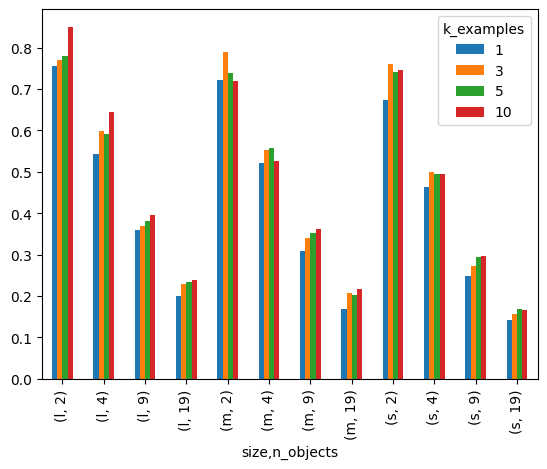

In [147]:
# make a graph of the breakdown
fig, ax = plt.subplots()
df_a.groupby(['size', 'n_objects', 'k_examples'])['correct'].mean().unstack().plot(kind='bar', ax=ax)

<Axes: xlabel='size,n_objects'>

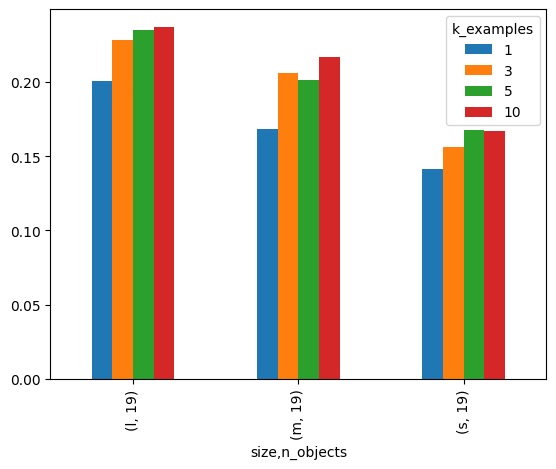

In [148]:
# make a graph of the breakdown
fig, ax = plt.subplots()
df_a[df_a["n_objects"] == 19].groupby(['size', 'n_objects', 'k_examples'])['correct'].mean().unstack().plot(kind='bar', ax=ax)

In [149]:
df.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC',
       'target class name'],
      dtype='object')

<Axes: xlabel='target class name'>

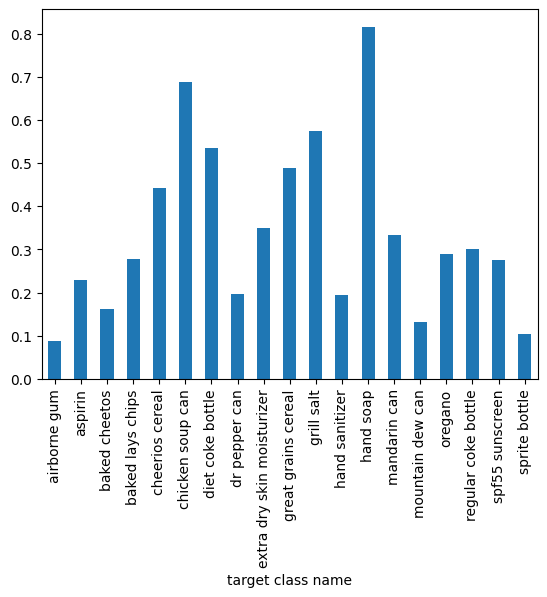

In [150]:
# make a graph of the accuracy by target_class for the model size l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['target class name'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: xlabel='train blind'>

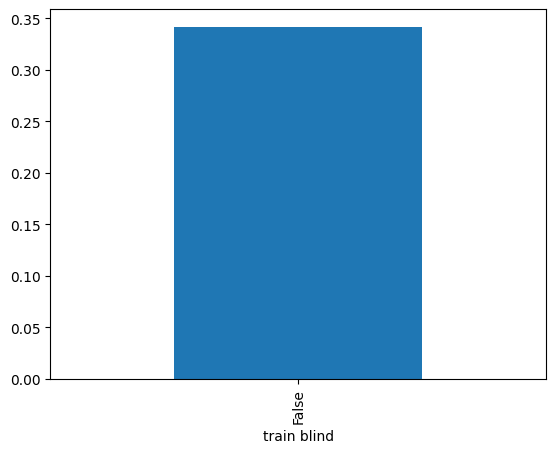

In [151]:
# make a graph of the accuracy according to the blind attribute for the model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['train blind'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: title={'center': 'correct'}, xlabel='train blind'>

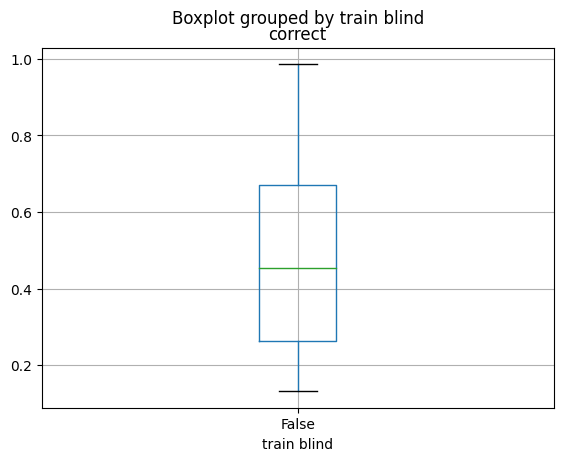

In [152]:
grouped_df = df_a[df_a['size'] == 'l'].groupby(['train blind', "seed"])['correct'].mean().reset_index()

fig, ax = plt.subplots()
grouped_df.boxplot(column='correct', by='train blind', ax=ax)

<Axes: xlabel='illuminated'>

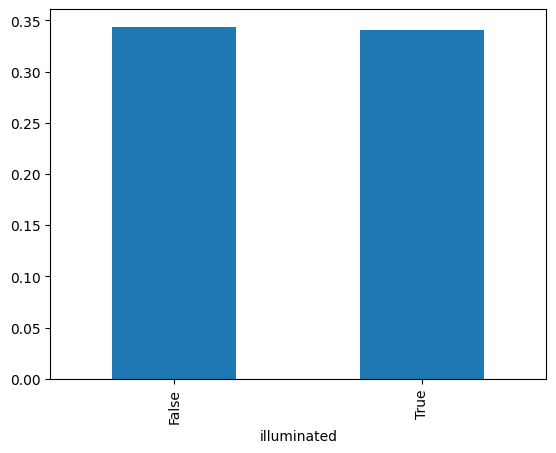

In [153]:
# make graph according to illumination still for the model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['illuminated'])['correct'].mean().plot(kind='bar', ax=ax)

<Axes: xlabel='train hand'>

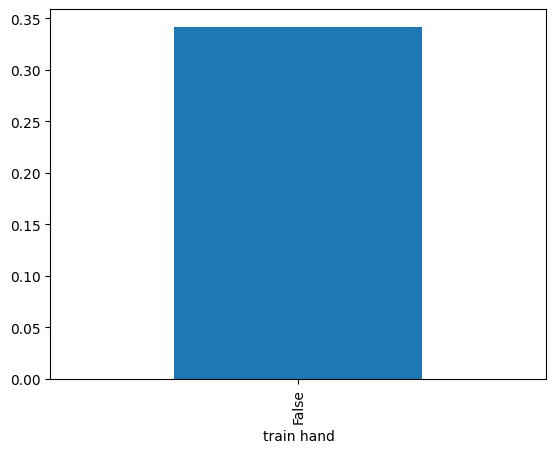

In [154]:
# make the same graph with hand or no hand, still for model l
fig, ax = plt.subplots()
df_a[df_a['size'] == 'l'].groupby(['train hand'])['correct'].mean().plot(kind='bar', ax=ax)

In [155]:
df[df["n_objects"] == 9].groupby(["seed"])["correct"].mean()

seed
14895     0.425926
14896     0.402469
14897     0.319753
14898     0.436420
14899     0.453086
            ...   
971496    0.335802
971497    0.358025
971498    0.343210
971499    0.358025
971500    0.318519
Name: correct, Length: 720, dtype: float64

# Top-k accuracies

In [156]:
from sklearn.metrics import top_k_accuracy_score

In [157]:
def measure_topk(df, k=5):
    return top_k_accuracy_score(df["target_class"], df[prob_cols], k=k)

In [158]:
measure_topk(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)], k=3)

0.5249220272904483

In [159]:
((df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)][prob_cols] > 0.9).sum(axis=1) > 1).mean()

0.7587621832358674

In [160]:
((df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10)][prob_cols]/19).sum(axis=1) > 0.5).mean()

0.5201072124756335

In [161]:
# compute the confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

def compute_confusion(df):
    cm = confusion_matrix(df["target_class"],
                        df[prob_cols].idxmax(axis=1).apply(lambda x: int(x.split("_")[-1])),
                        normalize=None)
    return cm

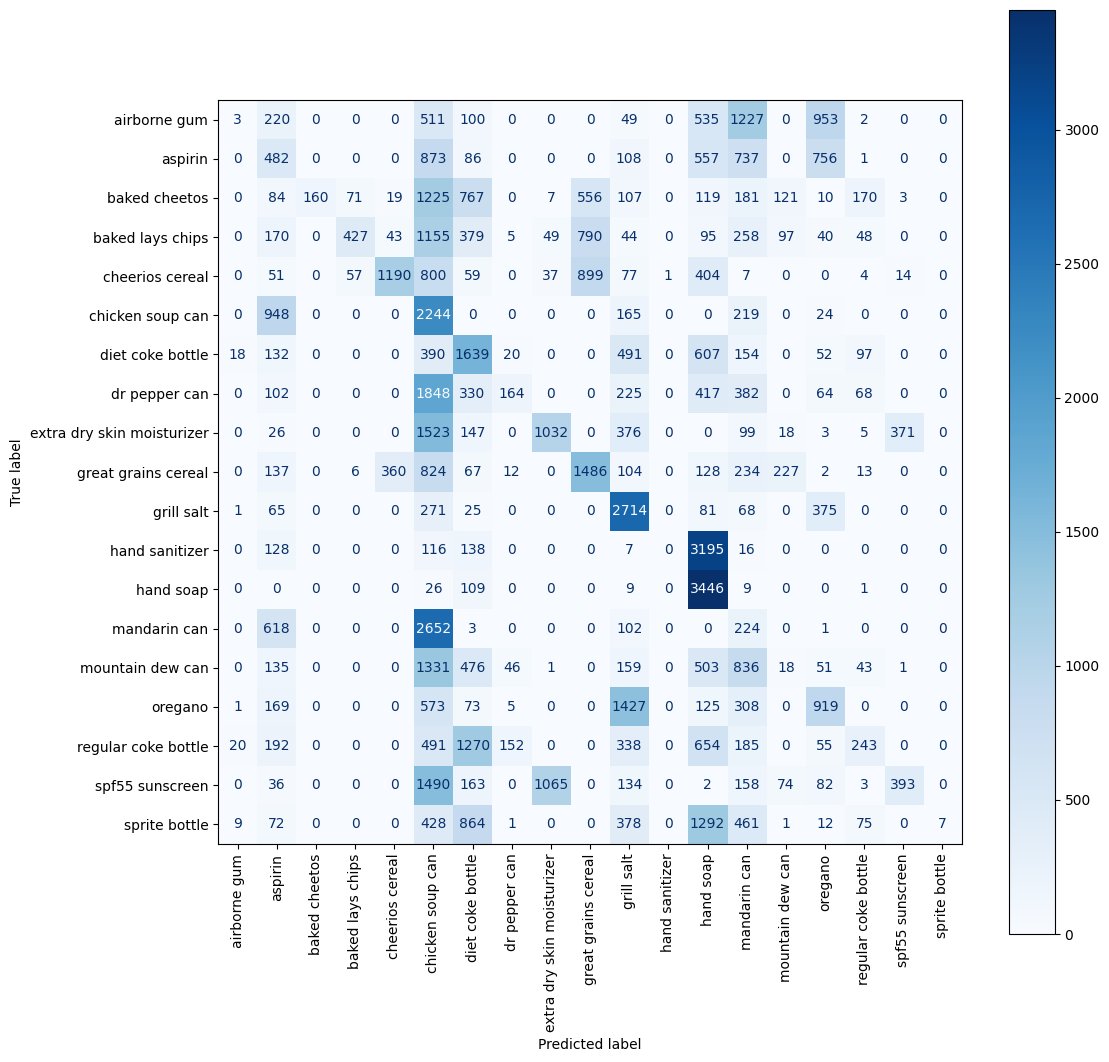

In [162]:
cm = compute_confusion(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 10) & (df_a["blind"] == False)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_mapping)

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

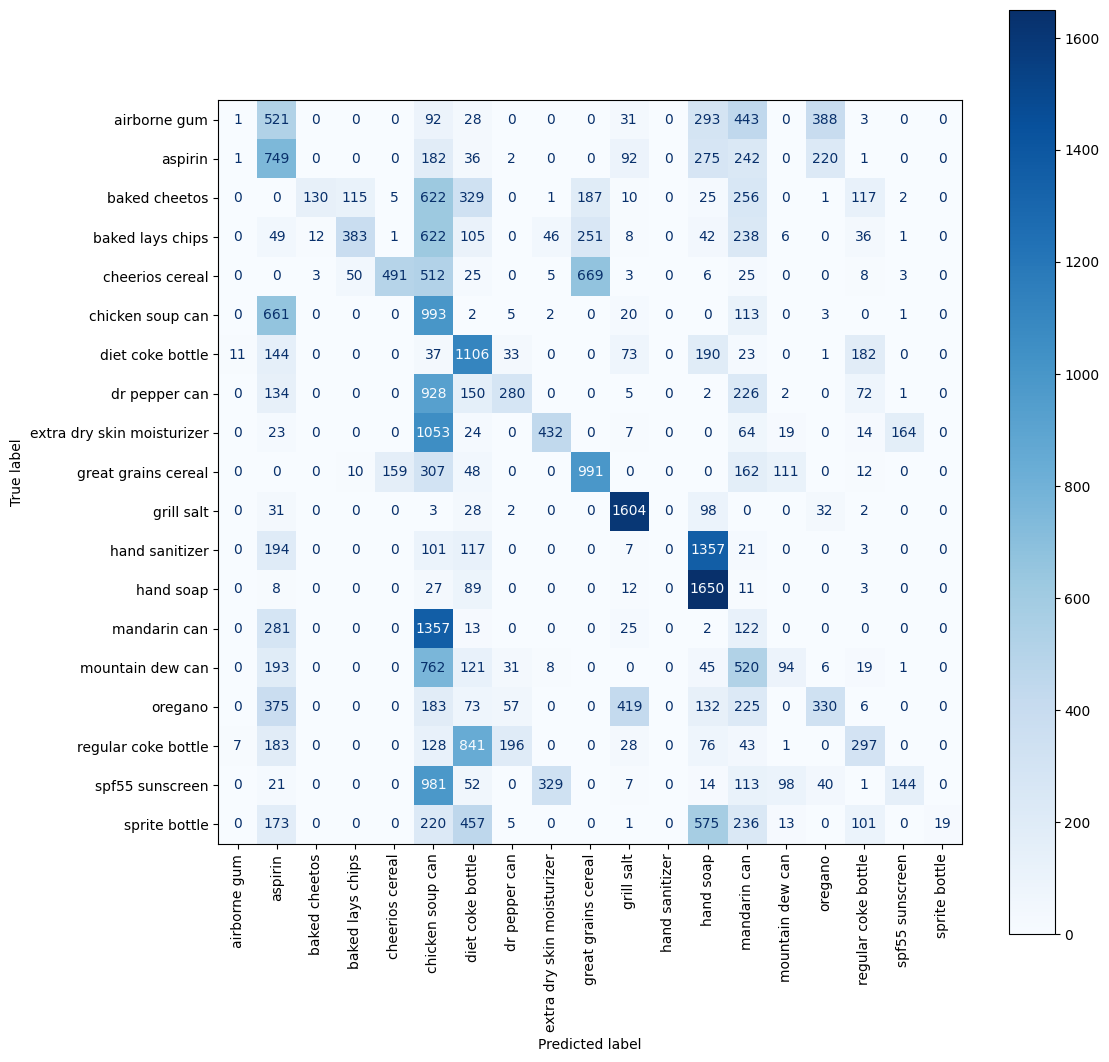

In [163]:
cm = compute_confusion(df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5) & (df_a["blind"] == False) & (df_a["clutter"] == False)])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cls_mapping)

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)

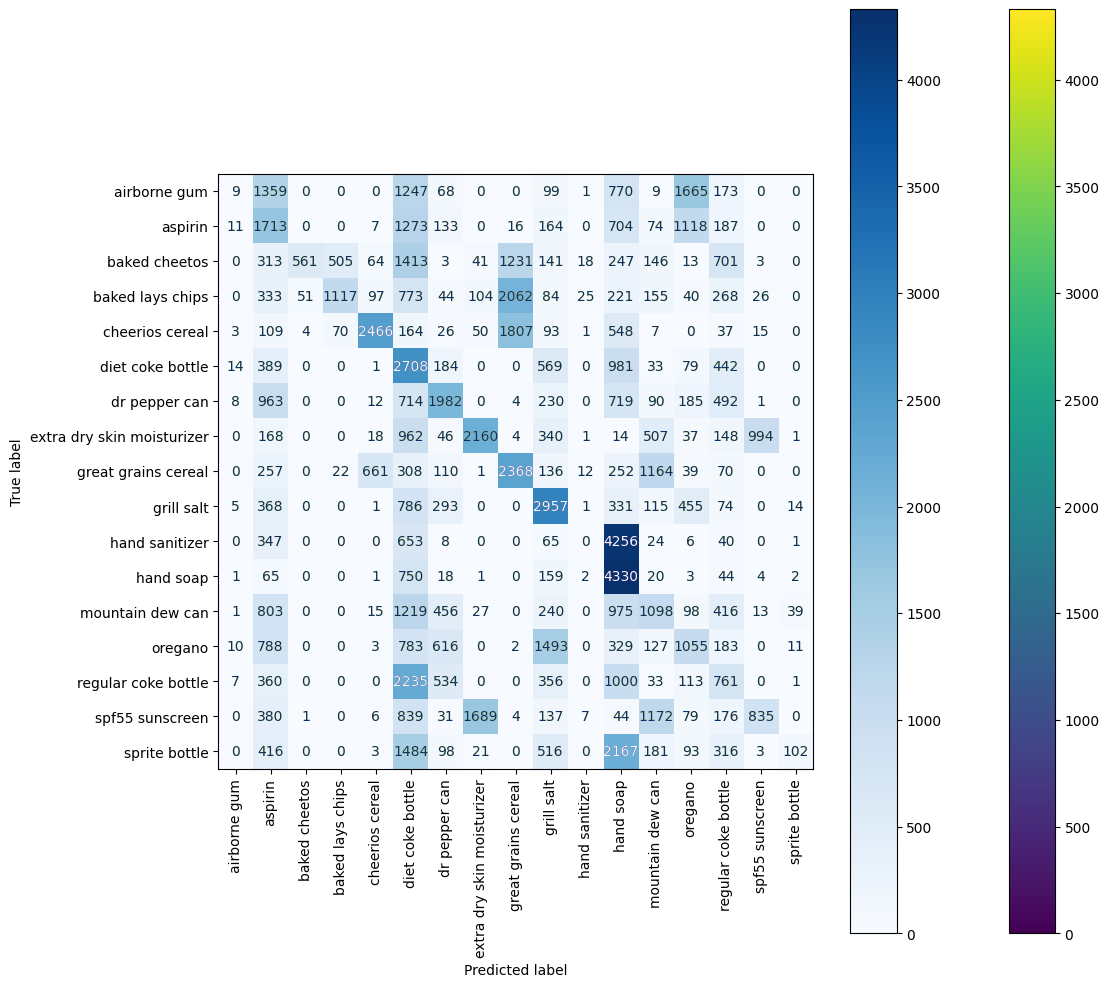

In [164]:
cmdf = df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5)]

# make the plot larger
fig, ax = plt.subplots(figsize=(12, 12))

retained_labels = [i for i,c in enumerate(cls_mapping) if c not in ("chicken soup can", "mandarin can")]

disp = ConfusionMatrixDisplay.from_predictions(cmdf["target_class"],
        cmdf[[f"prob_cls_{i}" for i in retained_labels]].idxmax(axis=1).apply(lambda x: int(x.split("_")[-1])),
    display_labels=[cls_mapping[i] for i in retained_labels],
    labels=retained_labels,
    ax=ax,
    xticks_rotation='vertical',
    )

disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)


In [165]:
df_a.groupby(["predicted_class"])["correct"].mean()

predicted_class
0     0.613737
1     0.255190
2     0.772760
3     0.752201
4     0.737217
5     0.163262
6     0.203443
7     0.381686
8     0.581060
9     0.451238
10    0.344514
11    0.644820
12    0.311868
13    0.165496
14    0.401617
15    0.308973
16    0.250554
17    0.655859
18    0.580723
Name: correct, dtype: float64

In [166]:
df_a.groupby(["target_class"])["correct"].mean()

target_class
0     0.065216
1     0.147799
2     0.094462
3     0.299546
4     0.306380
5     0.546743
6     0.388606
7     0.211610
8     0.383818
9     0.445094
10    0.381548
11    0.181355
12    0.730042
13    0.570370
14    0.179959
15    0.128235
16    0.259394
17    0.213868
18    0.205324
Name: correct, dtype: float64

In [167]:
# count number of prediction by predicted class
c = df_a[(df_a["n_objects"] == 19) & (df_a["size"] == "l") & (df_a["k_examples"] == 5)].groupby(["predicted_class"]).size()
# display by class name
c.index = [cls_mapping[i] for i in c.index]
c / c.sum()

airborne gum                  0.000380
aspirin                       0.080984
baked cheetos                 0.005302
baked lays chips              0.012076
cheerios cereal               0.023830
chicken soup can              0.251296
diet coke bottle              0.118119
dr pepper can                 0.014279
extra dry skin moisturizer    0.028275
great grains cereal           0.055390
grill salt                    0.075936
hand sanitizer                0.000468
hand soap                     0.162749
mandarin can                  0.092641
mountain dew can              0.008694
oregano                       0.033762
regular coke bottle           0.025867
spf55 sunscreen               0.009698
sprite bottle                 0.000253
dtype: float64

In [168]:
# count number of prediction by predicted class
c = df_a.groupby(["predicted_class"]).size()
# display by class name
c.index = [cls_mapping[i] for i in c.index]
c

airborne gum                   12375
aspirin                        64740
baked cheetos                  13708
baked lays chips               46449
cheerios cereal                47876
chicken soup can              405079
diet coke bottle              222455
dr pepper can                  62271
extra dry skin moisturizer     75025
great grains cereal           115407
grill salt                    127783
hand sanitizer                 31843
hand soap                     280202
mandarin can                  396408
mountain dew can               54039
oregano                        46318
regular coke bottle           120010
spf55 sunscreen                39972
sprite bottle                  41240
dtype: int64

In [169]:
df_a.columns

Index(['repeat', 'seed', 'hand', 'blind', 'illuminated', 'torch',
       'volume_portrait', 'clutter', 'target_class', 'predicted_class',
       'predicted_prob', 'correct', 'prob_cls_0', 'prob_cls_1', 'prob_cls_2',
       'prob_cls_3', 'prob_cls_4', 'prob_cls_5', 'prob_cls_6', 'prob_cls_7',
       'prob_cls_8', 'prob_cls_9', 'prob_cls_10', 'prob_cls_11', 'prob_cls_12',
       'prob_cls_13', 'prob_cls_14', 'prob_cls_15', 'prob_cls_16',
       'prob_cls_17', 'prob_cls_18', 'size', 'train blind', 'train clutter',
       'train hand', 'n_objects', 'k_examples', 'augment', 'WC',
       'target class name'],
      dtype='object')

In [170]:
target_cls_probs = df_a.apply(lambda x: x["prob_cls_" + str(x["target_class"])], axis=1)

In [171]:
df_a["target_class"].iloc[102600], df_a["prob_cls_9"].iloc[102600]

(9, 0.0650804713368415)

In [172]:
target_cls_probs.iloc[102600]

0.0650804713368415

In [173]:
prob_abs_diff = df_a[prob_cols].apply(lambda x: np.abs(x.to_numpy() - target_cls_probs.to_numpy()))

In [174]:
prob_diff = df_a["predicted_prob"] - target_cls_probs

<Axes: >

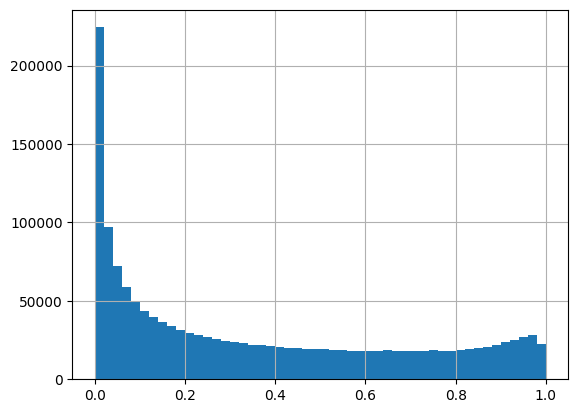

In [175]:
fig, ax = plt.subplots()
prob_diff[df_a["correct"] == False].hist(bins=50, ax=ax)

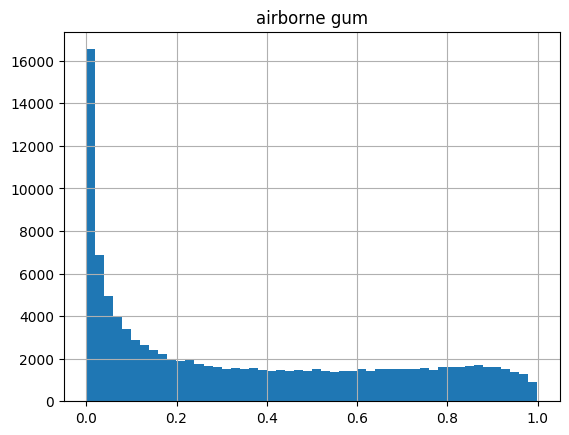

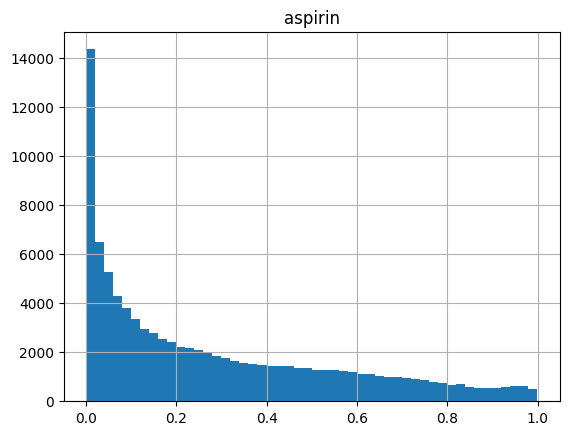

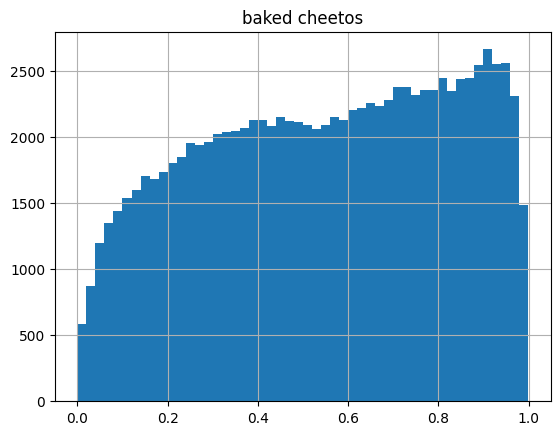

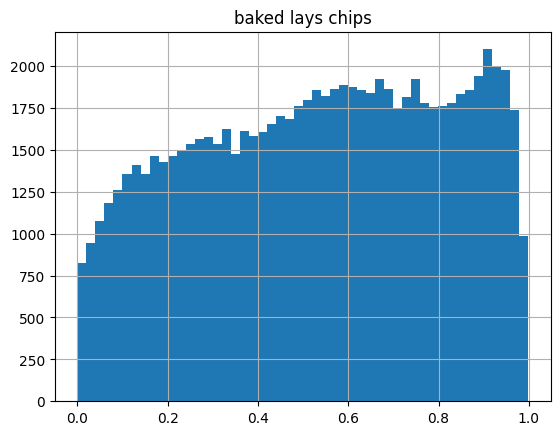

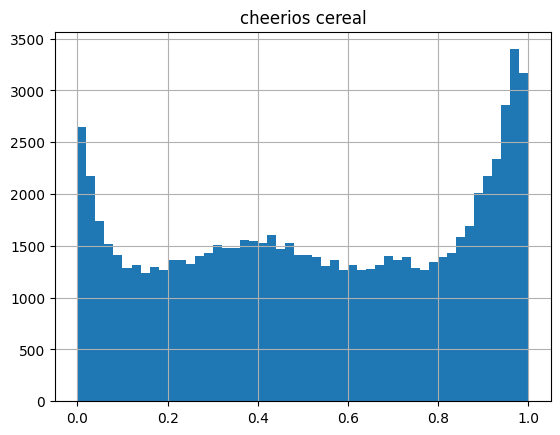

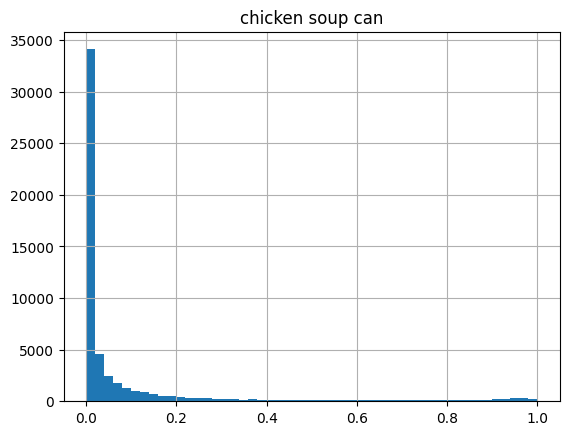

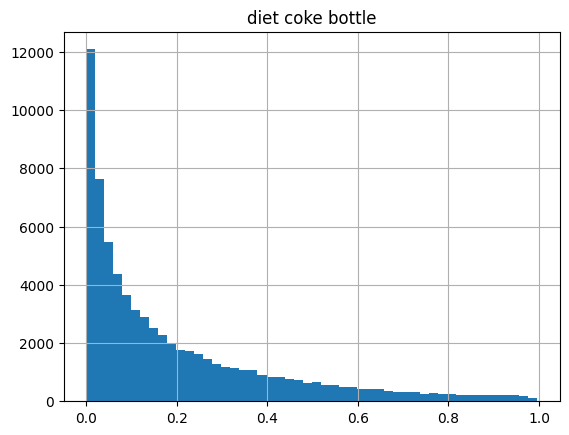

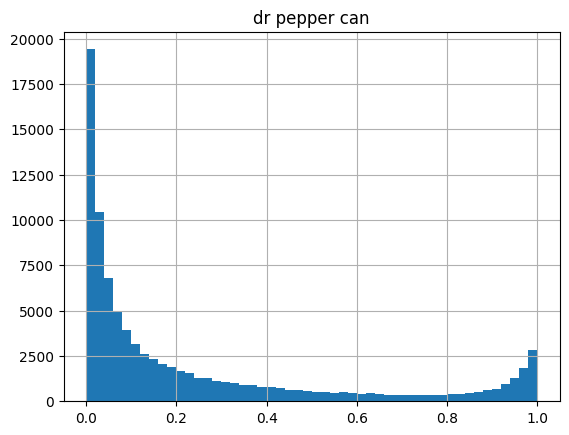

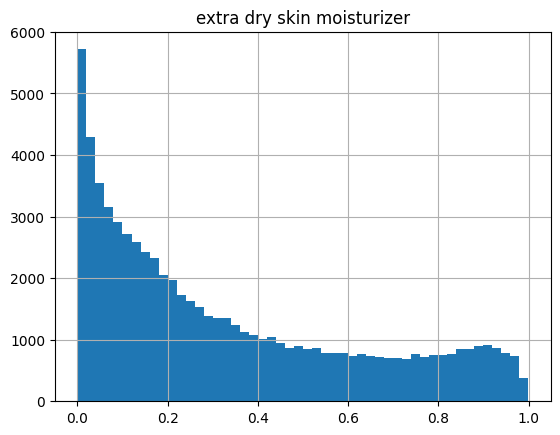

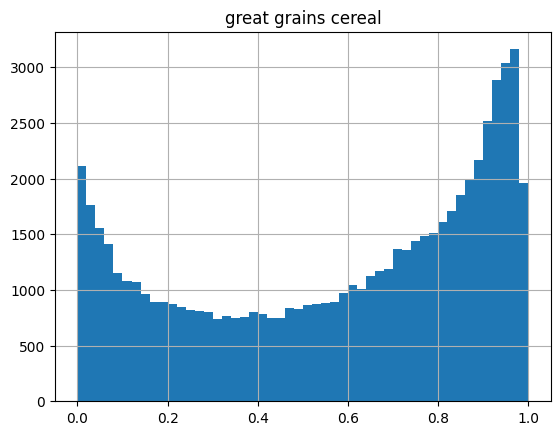

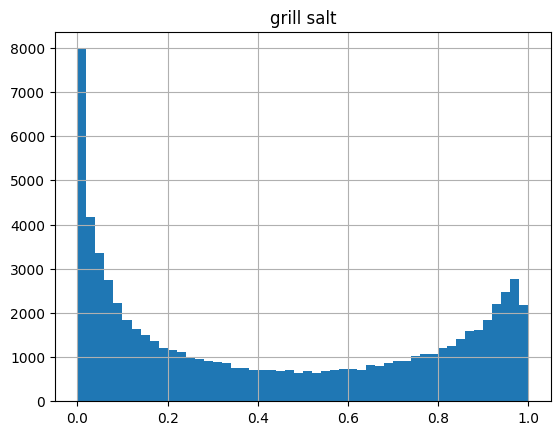

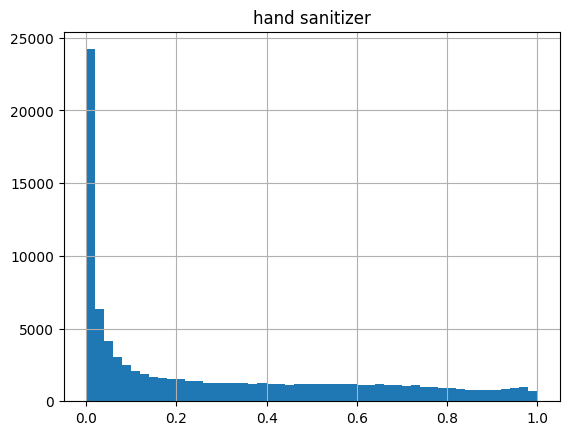

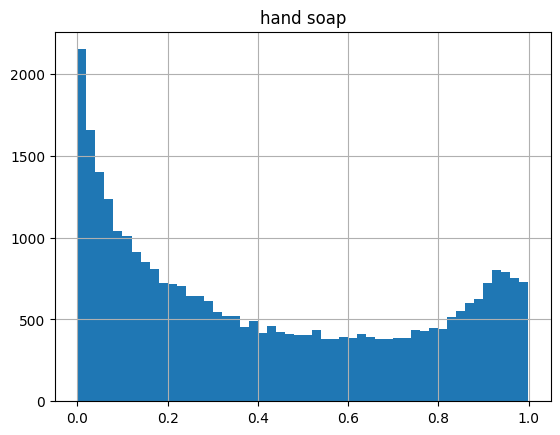

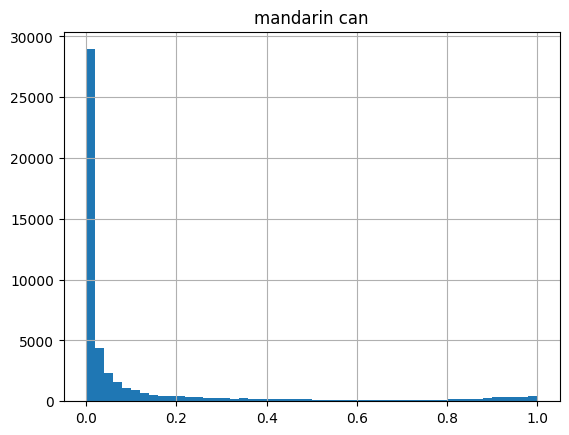

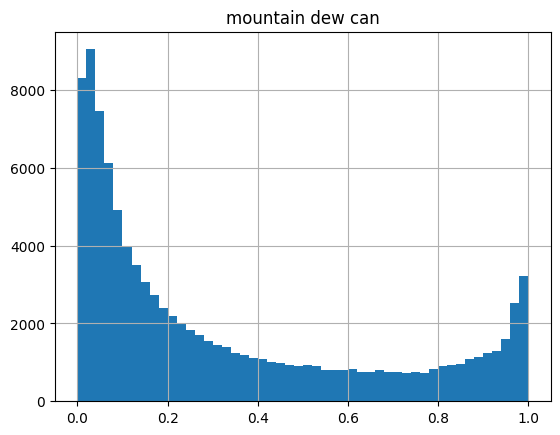

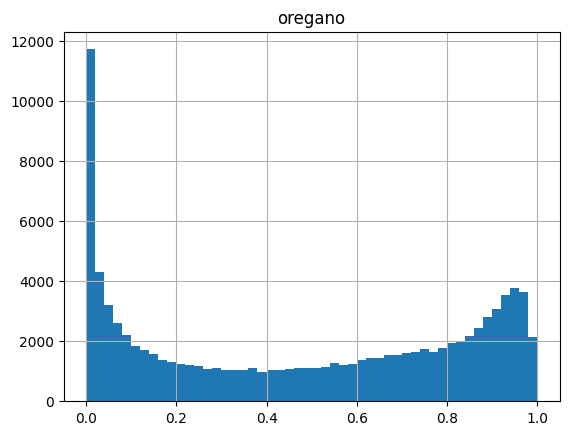

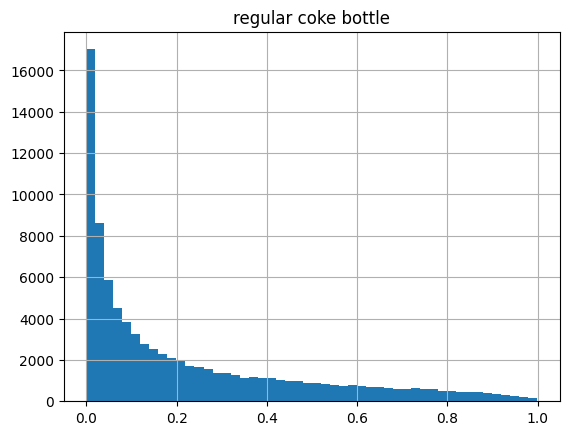

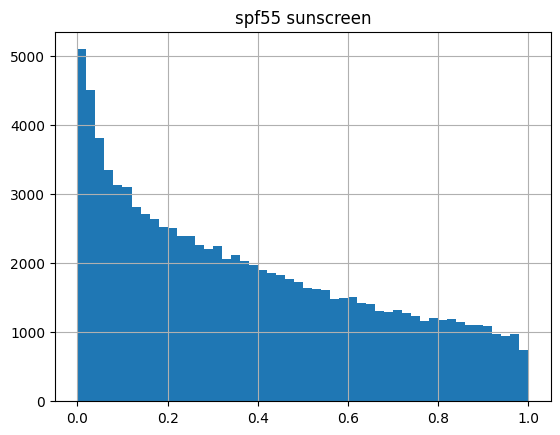

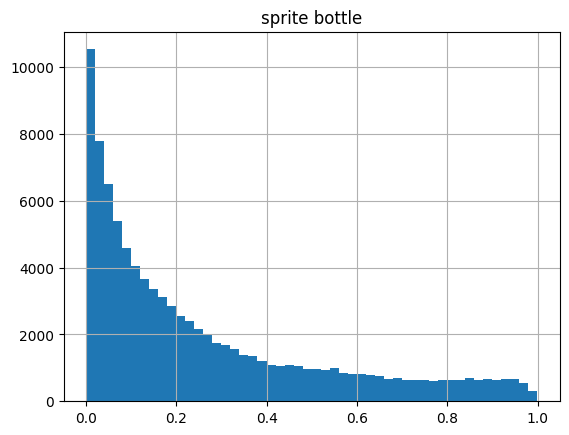

In [176]:
# plot for each class
for i in range(19):
    fig, ax = plt.subplots()
    # [f"prob_cls_{i}"]
    prob_diff[(df_a["correct"] == False) & (df_a["target_class"] == i)].hist(bins=50, ax=ax)
    plt.title(cls_mapping[i])